# First run eda_customers!

In [76]:
# How many rows are there in tx?

import pandas as pd
tx = pd.read_parquet("../data/processed/transactions_canonical.parquet")
a = pd.read_parquet("../data/processed/articles_clean.parquet", columns=["sku", "groupId", 'category', 'brand'])
tx = tx.drop(columns=["invoiceEmail", "orderLineId"], errors="ignore")



In [77]:
print(len(tx))

312079


In [78]:
# ensure sku column names match in both frames;
# tx = tx.rename(columns={'articleSku':'sku'})  # example if needed

cols = ["groupId", "sku", "category", "brand"]
a_dedup = a[cols].drop_duplicates(subset=["groupId", "sku"])

tx = tx.merge(
    a_dedup,
    on=["groupId", "sku"],
    how="left",
    validate="many_to_one"  # raises if a still has duplicate (groupId, sku)
)


In [82]:
# Save all rows where both category and brand are unknown/missing/na/none (case-insensitive),
# and ensure the output is unique on sku

def is_unknown(val):
    if pd.isna(val):
        return True
    s = str(val).strip().lower()
    return s in {"unknown", "none", "na", ""}

mask = tx.apply(
    lambda row: is_unknown(row["category"]) and is_unknown(row["brand"]),
    axis=1
)

unknown_rows = tx[mask].drop_duplicates(subset=["sku"])
unknown_rows.to_csv("/workspace/data/processed/avoid_names.csv", sep="\t", index=False)


In [80]:
print(len(tx))

312079


In [56]:
tx.dtypes


orderId                object
shopUserId             object
created                object
currencyId             object
sku                    object
groupId                object
quantity               object
price                  object
name                   object
type                   object
invoiceCity    string[python]
category       string[python]
brand          string[python]
dtype: object

In [57]:
tx.isna().mean()

orderId        0.000000
shopUserId     0.000000
created        0.000000
currencyId     0.000000
sku            0.000000
groupId        0.000000
quantity       0.000000
price          0.000000
name           0.000000
type           0.000000
invoiceCity    0.000000
category       0.000003
brand          0.000003
dtype: float64

In [58]:
# Output rows where the price value is 6 digits or more
six_digit_price_rows = tx[tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6,}')]
six_digit_price_rows

# For rows where price is exactly 6 digits, set price to the last 3 digits (e.g., 449399.0 -> 399.0)
mask_six_digit = tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6}')
# Fix prices in-place for those rows
def fix_six_digit_price(val):
    s = str(val).strip().replace('.0', '')
    if len(s) == 6 and s.isdigit():
        return float(s[-3:])
    return val

tx.loc[mask_six_digit, 'price'] = tx.loc[mask_six_digit, 'price'].apply(fix_six_digit_price)


In [59]:
print(len(tx))

312079


## Remove known bugs

In [60]:
# Keep only rows where 'created' date is on or after 2024-06-01 to avoid migration bugs
tx['created'] = pd.to_datetime(tx['created'], errors='coerce')
tx = tx[tx['created'] >= pd.to_datetime('2024-06-01')]

In [61]:
print(len(tx))

308351


In [62]:
tx.head()

,orderId,shopUserId,created,currencyId,sku,groupId,quantity,price,name,type,invoiceCity,category,brand
0,869808,912267,2025-10-06 14:50:27,134,280056-0038,280056,1,1500,Vinterkänga med dubb,telephone,Svärdsjö,"Skor,Skor & tofflor",Åshild
1,869796,912257,2025-10-06 14:44:44,134,260810-2090,260802,1,499,Bh utan bygel Broderie Anglaise,telephone,Lidköping,"Bh utan bygel,Bh,Underkläder",Miss Mary
2,869792,418342,2025-10-06 14:38:56,40,210774-5254,210773,1,318,Top,telephone,Bevtoft,"Överdelar,Toppar",Åshild
3,869792,418342,2025-10-06 14:38:56,40,210784-5254,210784,1,318,Tunika,telephone,Bevtoft,"Överdelar,Tunikor",Åshild
4,869792,418342,2025-10-06 14:38:56,40,200975,200975,1,49,Taske,telephone,Bevtoft,"Accessoarer,Väskor",Åshild


## Unify currenies to SEK for price bucketing

In [63]:
import pandas as pd
import requests

currencyid_to_country = {
    "40":  "DK",
    "134": "SE",
    "103": "NO",
    "50":  "FI",
}

def fetch_sek_rates():
    resp = requests.get(
        "https://api.frankfurter.app/latest",
        params={"from": "EUR", "to": "SEK,DKK,NOK"},
        timeout=10,
    )
    resp.raise_for_status()
    rates = resp.json()["rates"]
    sek_per_eur = rates["SEK"]
    dkk_per_eur = rates["DKK"]
    nok_per_eur = rates["NOK"]
    return {
        "DK": sek_per_eur / dkk_per_eur,
        "NO": sek_per_eur / nok_per_eur,
        "SE": 1.0,
        "FI": sek_per_eur,
    }

tx["currencyId"] = tx["currencyId"].astype("string").str.strip()
tx["currency_country"] = tx["currencyId"].map(currencyid_to_country)
conversion_rates = fetch_sek_rates()
tx["sek_rate"] = tx["currency_country"].map(conversion_rates)
tx["price"] = pd.to_numeric(tx["price"], errors="coerce")
tx["price_sek"] = (tx["price"] * tx["sek_rate"]).round(0).astype("Int64")


Price (SEK) statistics (1st to 99th percentile):
  Count: 302,871
  Mean: 285.05
  Median: 234.00
  Std: 193.93
  Min (1st percentile): 18.00
  Max (99th percentile): 1,100.00


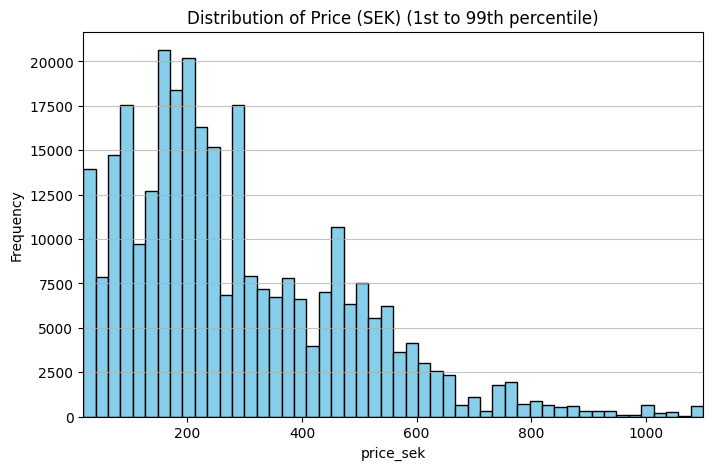

In [64]:
import matplotlib.pyplot as plt

# Show key statistics in numbers
price_sek = tx["price_sek"].dropna()
q_low = price_sek.quantile(0.01)
q_high = price_sek.quantile(0.99)
price_sek_trimmed = price_sek[(price_sek >= q_low) & (price_sek <= q_high)]

print("Price (SEK) statistics (1st to 99th percentile):")
print(f"  Count: {price_sek_trimmed.count():,}")
print(f"  Mean: {price_sek_trimmed.mean():,.2f}")
print(f"  Median: {price_sek_trimmed.median():,.2f}")
print(f"  Std: {price_sek_trimmed.std():,.2f}")
print(f"  Min (1st percentile): {q_low:,.2f}")
print(f"  Max (99th percentile): {q_high:,.2f}")

plt.figure(figsize=(8, 5))
plt.hist(
    price_sek_trimmed, 
    bins=50, 
    color="skyblue", 
    edgecolor="black"
)
plt.title("Distribution of Price (SEK) (1st to 99th percentile)")
plt.xlabel("price_sek")
plt.ylabel("Frequency")
plt.xlim(q_low, q_high)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [65]:
# Read the cleaned customers data from Parquet, do not change dtypes
customers = pd.read_parquet("../data/processed/customers_clean.parquet")

# Merge the 'Age' and 'invoiceCity' columns from the customers dataframe into the transactions dataframe, matching on 'shopUserId'
# This adds the 'Age' and 'invoiceCity' information for each transaction, using a left join to keep all transactions
tx = tx.merge(customers[["shopUserId", "Age", "Gender"]], on="shopUserId", how="left")

In [66]:
# Keep customers where age is between 10 and 105, or where age is NaN
tx = tx[
    (tx['Age'].isna()) |
    ((tx['Age'] <= 105) & (tx['Age'] >= 10))
]

In [67]:
tx.isna().mean()

orderId             0.000000
shopUserId          0.000000
created             0.000000
currencyId          0.000000
sku                 0.000000
groupId             0.000000
quantity            0.000000
price               0.000003
name                0.000000
type                0.000000
invoiceCity         0.000000
category            0.000003
brand               0.000003
currency_country    0.000000
sek_rate            0.000000
price_sek           0.000003
Age                 0.357615
Gender              0.357615
dtype: float64

In [68]:
print("Unique values in 'type' column:", tx["type"].unique())


Unique values in 'type' column: ['telephone' 'web' 'email' 'letter' 'other']


# Line price

In [69]:
# Convert 'quantity' to numeric, round to nearest integer, and convert back to string (if needed)
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce").round().astype("Int64").astype(str)


In [70]:
print("Unique values of quantity:", tx["quantity"].unique())


Unique values of quantity: ['1' '2' '3' '4' '10' '6' '5' '7' '12' '16' '9' '8' '11' '15' '50' '176'
 '130' '19' '40' '20' '14' '229' '24' '18' '25' '999' '<NA>']


In [71]:
# Calculate line_total_sek as price_sek * quantity, ensuring both are numeric, rounded to nearest integer (no decimals), and drop rows where result is NA or 0
tx["price_sek"] = pd.to_numeric(tx["price_sek"], errors="coerce")
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce")
tx["line_total_sek"] = (tx["price_sek"] * tx["quantity"]).round()
# Ensure line_total_sek is numeric
tx["line_total_sek"] = pd.to_numeric(tx["line_total_sek"], errors="coerce")
# Drop rows where line_total_sek is NA or 0
tx = tx.dropna(subset=["line_total_sek"])
tx = tx[tx["line_total_sek"] != 0]


# Country remap COUNTRY_MAP_ALPHA = {"SE": "Sweden", "DK": "Denmark", "FI": "Finland", "NO": "Norway"}

In [72]:
COUNTRY_MAP_ALPHA = {"SE": "Sweden", "DK": "Denmark", "FI": "Finland", "NO": "Norway"}
tx["country"] = tx["currency_country"].map(COUNTRY_MAP_ALPHA).fillna(tx["currency_country"])
tx = tx.drop(columns=["currency_country"])


In [73]:
print("Number of unique shopUserId:", tx['shopUserId'].nunique())


Number of unique shopUserId: 61284


In [74]:
# Save cleaned transactions to Parquet without changing dtypes
tx.to_parquet("../data/processed/transactions_clean.parquet", index=False)

In [75]:
# Output the proportion of NA (missing) values for each column in tx
print(tx.isna().mean())


orderId           0.00000
shopUserId        0.00000
created           0.00000
currencyId        0.00000
sku               0.00000
groupId           0.00000
quantity          0.00000
price             0.00000
name              0.00000
type              0.00000
invoiceCity       0.00000
category          0.00000
brand             0.00000
sek_rate          0.00000
price_sek         0.00000
Age               0.35801
Gender            0.35801
line_total_sek    0.00000
country           0.00000
dtype: float64
